In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import datetime as dt

In [2]:
# matplotlib에게 notebook에서 그림을 그리도록 지시
%matplotlib inline
# Jupyter Notebook 상에서 한글이 깨지지 않고 나오도록 조치
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# config 설정으로 고화질 도표 생성
%config InlineBackend.figure_format = 'svg'

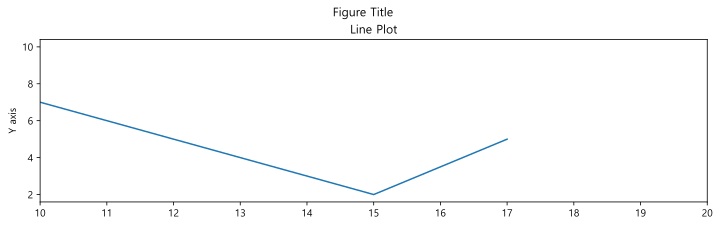

In [9]:
x = [-3, 5, 7]
y = [10, 2, 5]
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(x, y)
ax.set_xlim(0, 10)
ax.set_ylabel('Y axis')
ax.set_title('Line Plot')
fig.suptitle('Figure Title', y=1.03)
ax.set_xticks(range(0, 11), labels=range(10, 21))
plt.show()

In [11]:
p1 = Path.cwd() / 'back_data'
alta = pd.read_csv(p1 / 'alta-noaa-1980-2019.csv', parse_dates=['DATE'], index_col='DATE')
alta.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DAPR,DASF,MDPR,MDSF,PRCP,...,SNWD,TMAX,TMIN,TOBS,WT01,WT03,WT04,WT05,WT06,WT11
DATE,,,,,,,,,,,,,,,,,,,,,
1980-01-01,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.10,...,29.0,38.0,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.43,...,34.0,27.0,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.09,...,30.0,27.0,12.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.00,...,30.0,31.0,18.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,USC00420072,"ALTA, UT US",40.5905,-111.6369,2660.9,NaN,NaN,NaN,NaN,0.00,...,30.0,34.0,26.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
data = (alta
        .sort_index()
        .loc['2018-09':'2019-08', 'SNWD']
)
data.head()

DATE
2018-09-01    0.0
2018-09-02    0.0
2018-09-03    0.0
2018-09-04    0.0
2018-09-05    0.0
Name: SNWD, dtype: float64

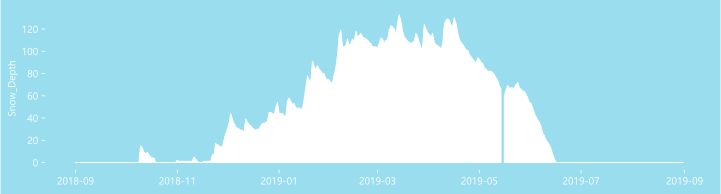

In [21]:
blue = '#99ddee'
white = '#ffffff'
fig, ax = plt.subplots(figsize=(12, 3), linewidth=5, facecolor=blue)
ax.set_facecolor(blue)
for line in ['top', 'bottom', 'left', 'right']:
    ax.spines[line].set_visible(False)
# tick color와 label color를 모두 바꿔주기에 color's'
ax.tick_params(axis='both', colors=white)
ax.set_ylabel('Snow_Depth', color=white)
ax.fill_between(data.index, data, color=white)